# Section 7. Classification

#### Instructor: Pierre Biscaye

The content of this notebook draws on material from UC Berkeley D-Lab's Python Machine Learning [course](https://github.com/dlab-berkeley/Python-Machine-Learning).

A common task in computational research is to **classify** an object into a set of possible categories based on a set of features. In supervised machine learning, we can give an algorithm a dataset of training examples that say "here are specific features, and this is the target class it belongs to". With enough training examples, a model can be built that recognizes important features in determining an object's class. This model can then be used to predict the class of an object given its known features.

### Sections
1. Simple classification
2. Logistic regression
3. More model evaluation
4. Decision trees
5. Support vector machines (SVMs)

First let's import the main packages that we need for this notebook. We'll import some additional packages for other classification models later.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

## Penguin Data

Let's say that we are studying penguins in Antartica. We have body measurements and location data for a set of penguins of three different species: Adelie, Chinstrap, and Gentoo. We are interested in being able to differentiate between these three species based on their characteristics. First, let's take a look at our data set, loading what we preprocessed in the last notebook.

In [2]:
X_train = pd.read_csv('Data/penguins_X_train.csv')
X_test = pd.read_csv('Data/penguins_X_test.csv')
y_train = pd.read_csv('Data/penguins_y_train.csv')
y_test = pd.read_csv('Data/penguins_y_test.csv')

Let's start with just two penguin species: Adelie and Gentoo. 

In [3]:
X_train = X_train[y_train['species'].isin(['Adelie','Gentoo'])].reset_index()
X_test = X_test[y_test['species'].isin(['Adelie','Gentoo'])].reset_index()
y_train = y_train[y_train['species'].isin(['Adelie','Gentoo'])].reset_index()
y_test = y_test[y_test['species'].isin(['Adelie','Gentoo'])].reset_index()

## 1. Simple classification

Let's say that we wanted to assign a species to each unknown measured penguin. One way to do this is to assign all observations to the majority class. The code below shows the proportion of each species in the training data.

In [4]:
y_train.value_counts('species')/sum(y_train.value_counts('species'))

species
Adelie    0.550505
Gentoo    0.449495
dtype: float64

**Question:** If we want to maximize accuracy, which species label would we assign to all observations? 

This level of accuracy, called 'null accuracy' is our **baseline model**, and is the number that we will try to improve on with classification.

Let's get to know our dataset by conducting some exploratory data analysis. We'll be using some rudimentary data analysis to see there's a relationship between the independent variables across species.

Let's say that we decide that body mass might be a good way to differentiate between Adelie and Gentoo penguins. We can look at a plot of the histogram to see how the distribution of this variable changes between species.

<AxesSubplot:xlabel='body_mass_g', ylabel='Count'>

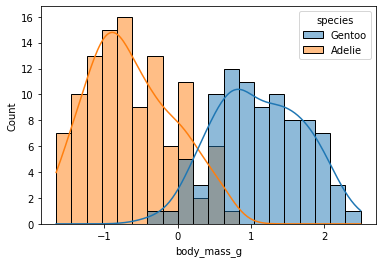

In [5]:
sb.histplot(data=X_train,
                x = 'body_mass_g',
                hue = y_train['species'],kde=True,bins=20)

**Question**: Where would you place a boundary line to minimize the overlap in the distribution? 

Now let's apply this same decision boundary to the test data. 

**Question:** Is this still the best boundary?

<AxesSubplot:xlabel='body_mass_g', ylabel='Count'>

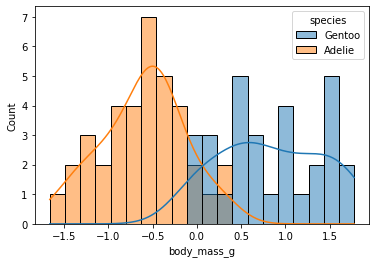

In [6]:
sb.histplot(data=X_test,
                x = 'body_mass_g',
                hue = y_test['species'],kde=True,bins=20)
#plt.axvline(.28,color= 'red')

This is the basic goal of classification. Based on your boundary criteria, you could **classify** all of the penguins. However there would be some error involved.

We can be more confident in our classification at the far ends of the distribution, and less confident where the distributions overlap. 

Suppose the training data had suggested an optimal threshold of 0.28 of normalized body mass. Let's calculate the accuracy of this decision model.

In [8]:
# 1. Copy X_test so we can create new columns
prediction_df = X_test.copy()

# 2. Create a 'prediction' column
prediction_df['prediction'] = np.where(
    prediction_df['body_mass_g'] < 0.28,  # condition
    'Adelie',                             # if True
    'Gentoo'                              # if False
)

# 3. Add the true species from y_test
prediction_df['species'] = y_test['species'].values

# 4. Compare 'prediction' to 'species'
prediction_df['correct'] = prediction_df['prediction'] == prediction_df['species']

# View the resulting DataFrame
prediction_df['correct'].mean()

0.8955223880597015

How much better is this approach to majority class classification? This is also know as baseline accuracy, as we'll discuss later.

In [7]:
# Accuracy of majority class classification
y_test.value_counts('species')/sum(y_test.value_counts('species'))

species
Adelie    0.552239
Gentoo    0.447761
dtype: float64

Clearly body mass is highly predictive of species. Now let's figure out how to separate out these groups mathematically to see if we can achieve even better performance. 

For this, we will start by using an algorithm called Logistic Regression.

## 2. Logistic Regression

Logistic regression is a supervised classification algorithm that is used to predict a binary outcome. Similar to linear regression, this model uses coefficients or betas to make its predictions. However unlike a linear regression, its predictions range from 0 to 1, where 0 and 1 stand for 'confidently class A and B' respectively. Predictions in the middle of this range show less confidence in the prediction.

The function for the logistic regression is:
$$ p(x) = \frac{1}{1 + e^{(-\beta_0+\beta_1x_1...)}}$$

where $\beta$ are the learned parameters and $x$ are the input features.

### Modeling with Logistic Regression

Logistic regression uses the same general steps as many other `sklearn` algorithms:
1. Initialize Model
2. Fit model on training data
3. Evaluate on training and testing datasets

Let's first train a univariate logistic regression model on the variable `body_mass_g`.

In [9]:
# A variety of parameters may be specified, but none are required
?LogisticRegression.fit

In [10]:
#1) Initialize Model
lr = LogisticRegression()

#2) Fit model
# Note that the X argument must be a 2D array; with a univariate model we must reshape the data
# Try running the below without .values.reshape(-1, 1) to see the error it returns
lr.fit(X_train['body_mass_g'].values.reshape(-1, 1), y_train['species'])

#3) Evaluate 
# The model will assign predicted species based on whether the estimated probability is closer to 0 or to 1
train_score = lr.score(X_train['body_mass_g'].values.reshape(-1, 1), y_train['species'])
test_score = lr.score(X_test['body_mass_g'].values.reshape(-1, 1), y_test['species'])

print("Training score:", train_score.round(3), "Testing score:", test_score.round(3))

Training score: 0.914 Testing score: 0.896


**Question:** How well did the model do compared to the two simple classification approaches?

### Multivariate Logistic Regression

The univariate logistic regression did a pretty good job at classifying the penguins. However, we have more than just body mass help predict species. 

For example, let's look at the combination of culmen depth and body mass in our data by using a scatterplot. Does adding in culmen depth help to further distinguish the species?

<AxesSubplot:xlabel='culmen_depth_mm', ylabel='body_mass_g'>

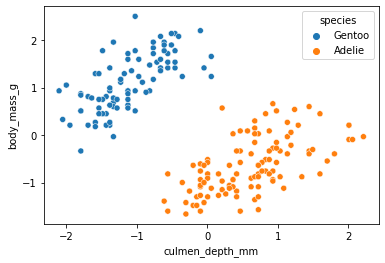

In [11]:
sb.scatterplot(data=X_train,
                x = 'culmen_depth_mm',
                y = 'body_mass_g',
                hue = y_train['species'])

In the two dimensional space, the intuition is that we want to draw a line that best separates the classes. 

**Question:** Is it possible to draw a line that completely separates the groups? If it is, this is a **linearly seperable** problem

Let's retrain the logistic model with two variables.

In [12]:
lr = LogisticRegression()
lr.fit(X_train[['body_mass_g','culmen_depth_mm']], y_train['species'])

train_score = lr.score(X_train[['body_mass_g','culmen_depth_mm']], y_train['species'])
test_score = lr.score(X_test[['body_mass_g','culmen_depth_mm']], y_test['species'])

print("Training score = {}, testing score = {}".format(train_score.round(3), test_score.round(3)))

Training score = 1.0, testing score = 1.0


While this doesn't happen often in real life, we got a perfect score! We could add more features to the model, but there isn't a need since our model is already behaving perfectly. Now let's take a look at the coefficients of the model. We reference the `lr.coef_` attribute to see the coefficients

In [13]:
coef = pd.Series(index=['body_mass_g','culmen_depth_mm'], data=lr.coef_[0])

coef.sort_values()

culmen_depth_mm   -2.710677
body_mass_g        2.486361
dtype: float64

**Question:** What do you think the *magnitude* and *sign* of the coefficients means about how these variables are related to each category?
**Hint:** Refer back to the scatter plot!

## 3. Model evaluation

We've covered accuracy already but there are many other ways to evaluate the performance of a classification model.

In a binary classification task, there are four major types of predictions:

[Confusion Matrix (Wikipedia)](https://en.wikipedia.org/wiki/Confusion_matrix): 
- true positive (TP): A test result that correctly indicates the presence of a condition or characteristic
- true negative (TN): A test result that correctly indicates the absence of a condition or characteristic
- false positive (FP): A test result which wrongly indicates that a particular condition or attribute is present
- false negative (FN): A test result which wrongly indicates that a particular condition or attribute is absent

Accuracy, which is the most common metric used with classification can be characterized as:

$$ Accuracy= \frac{\sum{\text{True Positives}}+\sum{\text{True Negatives}}}{\sum{\text{Total Population}}}$$

We can combine the prediction measures above to create three helpful metrics for evaluating classification: **precision**, **recall**, and **specificity**. 

1. **Precision**:
$$\frac{\sum{\text{True Positives}}}{\sum{\text{Predicted Positives}}}$$
2. **Recall** (or **Sensitivity**): 
$$\frac{\sum{\text{True Positives}}}{\sum{\text{Condition Positives}}}$$ 
3. **Specificity** (like recall for negative examples): 
$$\frac{\sum{\text{True Negatives}}}{\sum{\text{Condition Negatives}}}$$

Let's make a confusion matrix for the univariate logistic model and derive the recall and precision scores.

First we will retrain the model and make predictions on the test set.

Then we will use the `confusion_matrix()` function from `sklearn` to generate the confusion matrix.

Then we can calculate recall and precision.

In [14]:
lr.fit(X_train['body_mass_g'].values.reshape(-1, 1), y_train['species'])
preds = lr.predict(X_test[['body_mass_g']])

In [15]:
# Pass y_test and preds into confusion_matrix
confusion_matrix(y_test['species'], preds)

array([[36,  1],
       [ 6, 24]])

The rows indicate predictions being positive (top) or negative (bottom), and the columns indicate the truth being positive (left) or negative (right).

We can therefore read this as:
- TP: 36
- FP: 1
- TN: 24
- FN: 6

What is the precision and recall?

In [16]:
print('precision is {}'.format(round(36/(36+1),3)))
print('recall/sensitivity is {}'.format(round(36/(36+6),3)))

precision is 0.973
recall/sensitivity is 0.857


Depending on your task, other metrics than accuracy might be more beneficial to understanding your model's performance. At the very least, examining the confusion matrix is a great way to get a better sense of how your model is performing across classes.

## 4. Decision Trees

Let's now include all three species of penguin that we want to differentiate between. We will need to use other models that can handle two or more classes for classification. 

One such example is the Decision Tree Classifier (there is also a Decision Tree Regressor). In terms of logic, this process works like a flow chart. In the flow chart below the the features are information about how a lamp doesn't work. The classes (that we want to predict) are the actions that are taken to make the lamp work, based on the features.

![Alt](https://upload.wikimedia.org/wikipedia/commons/9/91/LampFlowchart.svg)

While the ultimate goal of classification remains the same, machine learning algorithms vary widely in terms of *how* they go about this task. The neat thing about `sklearn` is that many algorithms use the same syntax, which makes comparing their performance on a task fairly straightforward. However, each model will have different underlying parameters and methods to identify the optimal split. When you are using a new model it is helpful to read up on how the model works. 

The documentation is a great way to do that. For example, you can read the [documentation](https://scikit-learn.org/stable/modules/tree.html#tree) for the Decision Tree algorithm and to get answers to the following questions:

1) What are some advantages and disadvantages of the Decision Tree?
2) What measures do Decision Trees use to determine optimal split?
3) How do you import the Decision Tree from sklearn?

**Decision Trees** are a classification/regression supervised learning algorithm that uses a series of splits to make its predictions.

Decision Trees learn from the data by picking the feature-threshold that maximizes the information gain of the target variable. In other words it chooses a splitting point that produces the most imbalanced/pure proportions in the target variable. The goal of the model is to keep splitting until all the data in a terminal node or leaf are exclusively one class. A terminal node--where no further splitting occurs--is called a **leaf** in reference to the whole architecture being called a tree.

The model iterates through a set of values for each feature and then calculates statistics for each split (see 'criterion' below) and chooses a designated split based on the best statistic value.

**Parameters**

There are many [parameters](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) for the Decision Tree Classifier. A few relevant to this notebook are described here:

**criterion**: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity (default) and "log-loss" and “entropy” for the Shannon information gain.

**splitter**: The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split (default) and “random” to choose the best random split.

**max_depth**: The maximum depth of the tree, with default=None. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_split**: The minimum number of samples needed to split an internal node (default 2).

**min_samples_leaf**: The minimum number of samples required to be at a leaf node (default 1). A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

**max_features**: The number of features to consider when looking for the best split (default is no maximum).

Now let's train a decision tree model on the penguins data set. We are going to start with a default DT model, meaning we're not going to pass in any parameters of our own. Like we did before, we are going to fit a model and then evaluate it on the training and testing datasets. Let's start with a single x-feature.

In [17]:
# Import the functions
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Reload the traning and test data with all species
X_train = pd.read_csv('Data/penguins_X_train.csv')
X_test = pd.read_csv('Data/penguins_X_test.csv')
y_train = pd.read_csv('Data/penguins_y_train.csv')
y_test = pd.read_csv('Data/penguins_y_test.csv')

In [18]:
# Initialize model
dt = DecisionTreeClassifier()

# Fit model on the dataset
dt.fit(X_train[['body_mass_g']], y_train['species'])

# Derive the training accuracy score
dt.score(X_train[['body_mass_g']], y_train['species'])

0.7991967871485943

In [19]:
# Test score
dt.score(X_test[['body_mass_g']], y_test['species'])

0.6309523809523809

**Question:** Our testing score is considerably lower. When the testing score is lower than the training score, what does that mean?

We can take advantage of some of the parameters of the decision tree in order to help prevent overfitting of the model. Let's try a model in which we impose some constraints on the tree.

**Question:** From the documentation, what is one parameter that might help?

In [20]:
# Initialize
dt = DecisionTreeClassifier(max_depth=2)
# Fit 
dt.fit(X_train[['body_mass_g']], y_train['species'])

# Evaluate
train_score = dt.score(X_train[['body_mass_g']], y_train['species'])
test_score = dt.score(X_test[['body_mass_g']], y_test['species'])

print("Our training score is {} and our testing score is {}".format(train_score.round(3), test_score.round(3)))

Our training score is 0.739 and our testing score is 0.702


The gap between the two scores is considerably lower. Arguably we don't have an overfit model anymore. However, we could likely improve on the accuracy of this model by including more features.

### Tree Visualization

One big advantage of the Decision Tree is that it can be visualized no matter how many features were involved.

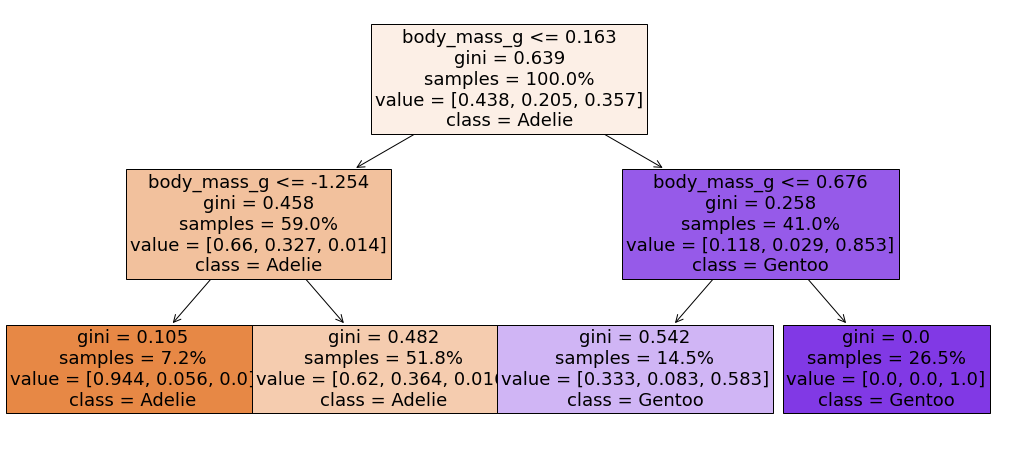

In [21]:
plt.figure(figsize=(18,8))
plot_tree(dt, feature_names=['body_mass_g'], class_names=["Adelie", "Chinstrap","Gentoo"], 
          filled = True, proportion=True, fontsize=18
         );

How do we interpret this?

The root node states
* `body_mass_g <= 0.163`: this is the criteria for splitting the decision tree.
* `gini = 0.639`: this is a measure of how 'impure' or heterogeneous the node is with respect to the target classes. It is calculated as $G(n)=\sum_{i=1}^K p_i (1-p_i)$.
* `samples = 100.0\%`: all samples are included in this node.
* `value=[0.438, 0.205, 0.357]`: these are the shares of the samples in the three classes of species. 
* `class = Adelie`: the predicted class at this node in the decision tree.

**Question** Which leaf is the most 'pure'? Which is the most 'impure'?

**Question** No leaves terminate in classifying any penguins as Chinstrap. Which current leaf would be most likely to result in such a classification if it was split once more?

**Question** Using the tree, how would we make predictions about the following penguins? How accurate are these predictions likely to be?
* Penguin A: Body Mass of .5
* Penguin B: Body Mass of 0

In the practice notebook, you can work on estimating a decision tree with more features to see how the performance improves.

### Pruning a Decision Tree

As with all prediction algorithms, we want to avoid overfitting. **Pruning** is a technique for reducing decision tree overfitting by simplifying the tree structure. In practice, pringing means removing subtrees or leaves that add little predicting power. Pruning a "fully-grown" tree model can help strike a balance between underfitting (too simple) and overfitting (too complex).

**Pre-pruning** can be accomplished by careful selection of hyperparameters. This prevents a tree from "over-growing" as it is estimated. The arguments `max_depth` and `min_samples_leaf` are examples of parameters that prevent a tree from going too deep (having too many splits) and from splitting the sample into leaves with very small samples.

**Post-pruning** involves predicting a complete tree with minimal pruning, estimating complexity of the whole tree and possible pruned sub-trees, and assigning a complexity penalty that helps target which sub-trees to prune. This is accomplished using `DecisionTreeClassifier(ccp_alpha=...)`, where `ccp_alpha` is the penalty parameter you specify, with a higher alpha imposes a greater complexity penalty. 

How to choose an appropriate alpha? You first estimate the Decision Tree Classifier without specifying `ccp_alpha`, and fit it to the training data. Then, pass `cost_complexity_pruning_path` on the resulting tree. You can then retrieve a range of alpha values you can iterate over to select one that maximizes validation performance.

I invite you to explore this tool in the practice notebook.

## 5. Classification with SVM

Now let's try another new model. The [Support Vector Machine](https://scikit-learn.org/stable/modules/svm.html#classification) is another class of machine learning algorithm that is used for classification, regression, and outlier detection.

For binary classification, SVMs aim to find the **hyperplane** that best separates two classes in a feature space by maximizing the margin, i.e., the distance between the hyperplane and the nearest data points from both classes (called support vectors).

**Question** How does SVM fit in with the **linearly separable** problem identified in the scatter plots in the first part of this notebook?

For multi-class problems, SVMs rely on decomposition strategies to reduce the problem into multiple binary classification tasks. The most common methods are:
1. One-vs-One (OvO) Strategy: Create an SVM classifier for every pair of classes. Each classifier distinguishes between a pair of classes (e.g., class 1 vs. class 2, class 1 vs. class 3, etc.). For prediction of a new input, each binary classifier votes for one of its two classes. The class with the most votes across all classifiers is assigned as the prediction.
2. One-vs-Rest (OvR) Strategy: Train an SVM classifier for each class. Each classifier distinguishes one class from all others (e.g., class 1 vs. the rest, class 2 vs. the rest, etc.). For prediction of a new input, it computes the decision function value for each classifier, and assign the class with the highest decision score.
3. Direct Multi-Class SVM (Single Optimization): Solve a single optimization problem that incorporates constraints for all classes simultaneously. This is less commonly used due to computational complexity.

Since we have three penguin classes, it is a multi-class problem. The default approach in the `SVC` function for this prediction problem is OvR.

We will choose two features of the data set to train our model on. Then, using the documentation for the support vector machine, we will:
- Initialize the model
- Fit it to the training data
- Evaluate the model on both the training and testing data

In [22]:
from sklearn.svm import SVC
?SVC

In [23]:
# Specify the desired features and target variable
X_train_subset = X_train[['body_mass_g','culmen_depth_mm']]
X_test_subset = X_test[['body_mass_g','culmen_depth_mm']]
y_train_subset = y_train['species']
y_test_subset = y_test['species']

##1) Initialize SVM
model = SVC()
##2) Train SVM on Training data 
model.fit(X_train_subset,y_train_subset)
##3) Evaluate SVM on Training and Test Data
print('Training score: {}'.format(model.score(X_train_subset,y_train_subset)))
print('Test score: {}'.format(model.score(X_test_subset,y_test_subset)))

Training score: 0.7951807228915663
Test score: 0.7976190476190477


Is the model underfit? Is it overfit?

How does it change with the addition of some additional features? Let's include the island data.

In [24]:
# Specify the desired features and target variable
X_train_subset = X_train[['body_mass_g','culmen_depth_mm','Dream','Torgersen']]
X_test_subset = X_test[['body_mass_g','culmen_depth_mm','Dream','Torgersen']]
y_train_subset = y_train['species']
y_test_subset = y_test['species']

##1) Initialize SVM
model = SVC()
##2) Train SVM on Training data 
model.fit(X_train_subset,y_train_subset)
##3) Evaluate SVM on Training and Test Data
print('Training score: {}'.format(model.score(X_train_subset,y_train_subset)))
print('Test score: {}'.format(model.score(X_test_subset,y_test_subset)))

Training score: 0.8433734939759037
Test score: 0.8571428571428571


What do you conclude?